In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict


from tqdm import tqdm
from glob import glob

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 16})

In [2]:
model_colors = {'DNABERT':"#D55E00",'DNABERT-3UTR':"#ffac6a", 
                '13-mer':"#CC79A7",
                'PhyloP-241way':"#ffd373",
                'PhyloP-100way':"#e69f00",
                'StateSpace':"#0072B2", 'StateSpace-SA':"#59c3ff", 
                'NTv2-250M':"#009E73", 'NTv2-250M-3UTR':"#00dea2"}

In [3]:
data_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/mlm/'

In [34]:
probs_dir = data_dir + 'human_3utr/probs/'

models = {'DNABERT': 'dnabert', 
          'DNABERT-3UTR': 'dnabert-3utr', 
          'NTv2-250M': 'ntrans-v2-250m',
          'NTv2-250M-3UTR': 'ntrans-v2-250m-3utr',
          'StateSpace': 'stspace', 
          'StateSpace-SA': 'stspace-spaw',
          'PhyloP-100way': 'PhyloP100',
          'PhyloP-241way':'PhyloP241',
         }

model_colors = {'DNABERT':"#D55E00",'DNABERT-3UTR':"#ffac6a", 
                'DNABERT2':"#3F3B6C",'DNABERT2-3UTR':"#adaad0",
                '13-mer':"#CC79A7",
                'PhyloP-241way':"#ffd373",
                'PhyloP-100way':"#e69f00",
                'StateSpace':"#0072B2", 'StateSpace-SA':"#59c3ff", 
                'NTv2-250M':"#009E73", 'NTv2-250M-3UTR':"#00dea2"}

In [35]:
def get_model(glob_path):
    res = {}
    for probas_file in glob(glob_path):
        #print(probas_file)
        with open(probas_file, 'rb') as f:
            fold_res = pickle.load(f)
            #fold_res = {seq_name:{'probs':prob,'seq':seq} for seq_name,prob,seq in zip(fold_res['seq_names'],fold_res['probs'],fold_res['seqs'])}
            fold_res = {seq_name:prob for seq_name,prob in zip(fold_res['seq_names'],fold_res['probs'])}
            res.update(fold_res)
    return res

In [36]:
all_model_probas = {}

for model, model_path in models.items():
    all_model_probas[model] = get_model(probs_dir + '/' + model_path + '/predictions*.pickle')
    print(f'{model} loaded, {len(all_model_probas[model])} sequences')

DNABERT loaded, 18134 sequences
DNABERT-3UTR loaded, 18134 sequences
NTv2-250M loaded, 18134 sequences
NTv2-250M-3UTR loaded, 18134 sequences
StateSpace loaded, 18134 sequences
StateSpace-SA loaded, 18134 sequences
PhyloP-100way loaded, 18134 sequences
PhyloP-241way loaded, 18134 sequences


In [37]:
mapping = {'A':0,'C':1,'G':2,'T':3}

In [38]:
human_fasta = data_dir + 'fasta/Homo_sapiens_rna.fa' #3'UTR on hegative strand should  be reverse complemented

human_utr = defaultdict(str)

with open(human_fasta, 'r') as f:
    for line in f:
        if line.startswith('>'):
            seq_name = line[1:].rstrip()
        else:
            human_utr[seq_name] += line.rstrip().upper()

In [39]:
def inv_mapping(i):
    indices = [0,1,2,3]
    indices.remove(i)
    return indices 

prob_ref = {model_name:[] for model_name in models}
inv_prob_alt = {model_name:[] for model_name in models}
ref_alt_ratio = {model_name:[] for model_name in models}

step_bp=10

for seq_name, seq in tqdm(human_utr.items()):
    for model_name in models:
        if seq_name in all_model_probas[model_name]:
            if 'PhyloP' in model_name:
                ref_probas = all_model_probas[model_name][seq_name][::step_bp]
            else:
                ref_probas = np.array([all_model_probas[model_name][seq_name][idx,mapping[seq[idx]]] for idx in range(0,len(seq),step_bp)])
                inv_alt_probas = np.array([1./all_model_probas[model_name][seq_name][idx,inv_mapping(mapping[seq[idx]])].flatten() for idx in range(0,len(seq),step_bp)])
                ratio = np.repeat(ref_probas[...,None],3,1)*inv_alt_probas
                inv_prob_alt[model_name].append(inv_alt_probas.reshape(-1)[::3])
                ref_alt_ratio[model_name].append(ratio.reshape(-1)[::3])
            prob_ref[model_name].append(ref_probas)

        
for model_name in models:
    prob_ref[model_name] = np.hstack(prob_ref[model_name])
    if not 'PhyloP' in model_name:
        inv_prob_alt[model_name] = np.hstack(inv_prob_alt[model_name])
        ref_alt_ratio[model_name] = np.hstack(ref_alt_ratio[model_name])

100%|██████████| 18134/18134 [01:22<00:00, 218.76it/s]


In [40]:
scores = {'$p_{ref}$':prob_ref, 'log($p_{alt}^{-1}$)':inv_prob_alt, 'log($p_{ref}$/$p_{alt}$)': ref_alt_ratio}

$p_{ref}$
"DNABERT":[0.16,0.692],"DNABERT-3UTR":[0.157,0.569],"NTv2-250M":[0.132,0.743],"NTv2-250M-3UTR":[0.167,0.426],"StateSpace":[0.162,0.605],"StateSpace-SA":[0.164,0.587],"PhyloP-100way":[-0.885,2.02],"PhyloP-241way":[-0.915,3.01],
log($p_{alt}^{-1}$)
"DNABERT":[0.916,3.51],"DNABERT-3UTR":[0.905,3.14],"NTv2-250M":[0.949,3.23],"NTv2-250M-3UTR":[1.09,2.07],"StateSpace":[0.934,3.23],"StateSpace-SA":[0.955,3.1],
log($p_{ref}$/$p_{alt}$)
"DNABERT":[-0.692,2.79],"DNABERT-3UTR":[-0.728,2.28],"NTv2-250M":[-0.82,2.62],"NTv2-250M-3UTR":[-0.587,1.05],"StateSpace":[-0.659,2.43],"StateSpace-SA":[-0.63,2.28],


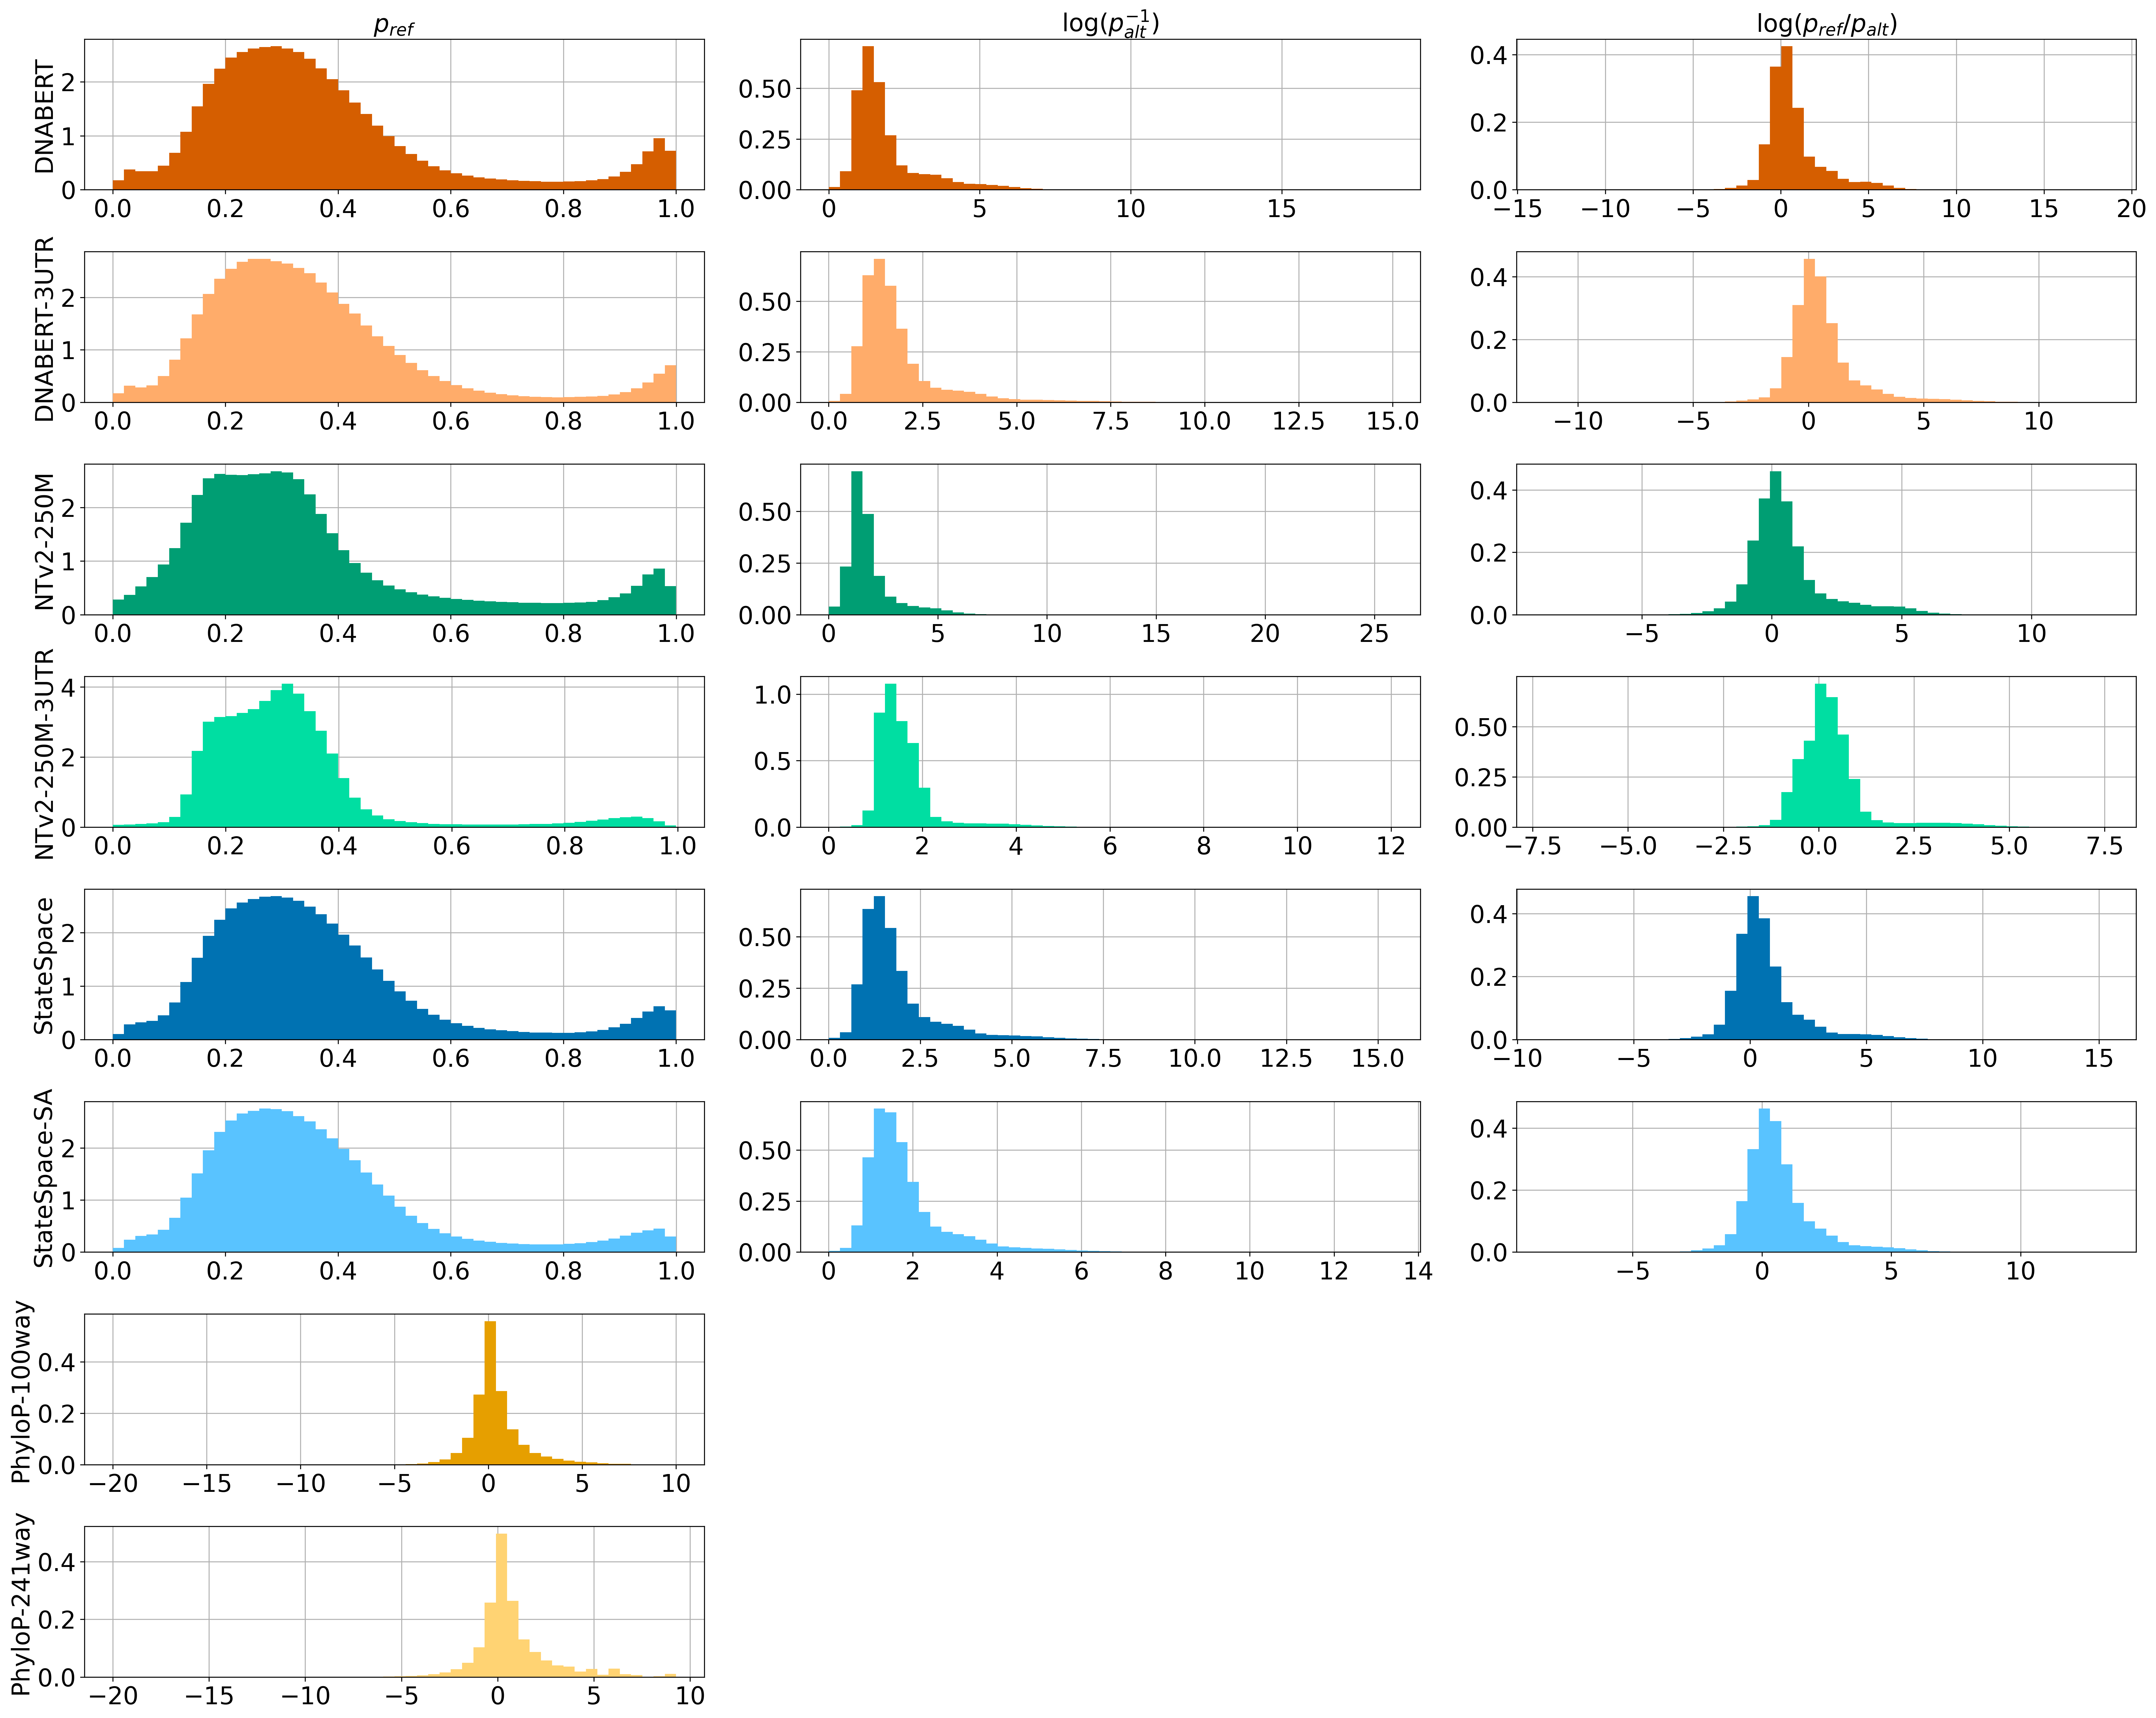

In [43]:
matplotlib.rcParams.update({'font.size': 20})

N_models = len(models)
N_scores = 3

#fig, axes = plt.subplots(N_scores,N_models,figsize=(20,5),dpi=300)
fig, axes = plt.subplots(N_models,N_scores,figsize=(25,20),dpi=300)

for col,score in enumerate(scores):
    print(score)
    for row,model_name in enumerate(models):
        ax = axes[row,col]
        data = scores[score][model_name]
        if len(data)>0:
            if score=='log($p_{alt}^{-1}$)' or score=='log($p_{ref}$/$p_{alt}$)':
                data = np.log(data)
            ax.hist(data, density=True, bins=50, color=model_colors[model_name])
            ax.grid(True)
            ax.set_axisbelow(True)
            if row==0:
                ax.set_title(score, fontsize=20)
            if col==0:
                ax.set_ylabel(model_name, fontsize=20)
            #ax.axvline(x=np.percentile(data,70), color='r', linestyle='--')
            #ax.axvline(x=np.percentile(data,10), color='r', linestyle='--')
            print(f'"{model_name}":[{np.nanpercentile(data,10):.3},{np.nanpercentile(data,90):.3}],',end='')
        else:
            ax.set_axis_off()
    print()
fig.tight_layout()